In [1]:
import recommender_system
from sklearn.metrics import mean_squared_error
from torch.multiprocessing import Pool
import pandas as pd
import datetime
import sqlite3

### Utilities

In [2]:
def load_from_database(
        db: str,
        table: str,
        columns: str,
):
    connection = sqlite3.connect('../database/' + db + '.db')
    df = pd.read_sql_query(
        str('SELECT ' + columns + ' FROM ' + table), con=connection
    )
    connection.close()
    return df


def save_to_database(
        db: str,
        table: str,
        df: pd.DataFrame
):
    connection = sqlite3.connect('../database/' + db + '.db')
    try:
        df.to_sql(name=table, con=connection, if_exists='replace')
    except Exception as e:
        raise e
    print('DataFrame has been saved successfully to: ' + db)

### Basic and cold-start scenario

In [3]:
df_train_input = load_from_database(db='review_en_train', table='review_en_train',
                                 columns='user_id, wine_id, note, rating, type_id')
df_test_input = load_from_database(db='review_en_test', table='review_en_test',
                                columns='user_id, wine_id, note, rating, type_id')

### Cross-domain

In [5]:
'''
1: 'Rotwein',
2: 'Weißwein',
3: 'Schaumwein',
4: 'Rosé',
24: 'Likörwein',
7: 'Dessertwein'
'''
df_train_input = df_train_input[df_train_input['type_id'] == 3]
df_test_input = df_test_input[df_test_input['type_id'] != 3]

In [5]:
user = 56640092
rated_train = df_en_train[df_en_train['user_id'] == user]['wine_id']
rated_test = df_en_test[df_en_test['user_id'] == user]['wine_id']
df_temp = df_en_train[df_en_train['wine_id'].isin(rated_train)]
print(len(df_temp))
print(len(df_temp[df_temp['user_id'].isin(
    df_en_test[df_en_test['wine_id'].isin(rated_test)]['user_id']
)]))

716
0


### Evaluate NLP Recommender

In [6]:
# Credits split method: https://stackoverflow.com/questions/2130016/splitting-a-list-into-n-parts-of-approximately-equal-length
def split(a, n):
    k, m = divmod(len(a), n)
    return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))


def start_nlp():
    df_intersection = list(set(df_test_input['user_id']) & set(df_train_input['user_id']))
    df_test = df_test_input[df_test_input['user_id'].isin(df_intersection)]
    df_train = df_train_input[df_train_input['user_id'].isin(df_intersection)]
    input_user_ids = df_intersection
    core_count = 4
    input_user_id_frames = split(input_user_ids, core_count)
    type = 'nlp'
    model = 'zero-shot'
    model_path = '../models/' + model
    """
        df_train: pd.DataFrame = args[0]
        df_test: pd.DataFrame = args[1]
        input_user_list = args[2]
        n_user: int = args[3]
        type_name: str = args[4]
        is_evaluation: bool = args[5]
        truncate: bool = args[6]
    """
    data: list = list()
    for i in range(core_count):
        data.append([
            df_train,
            df_test,
            input_user_id_frames[i],
            5,
            type,
            True,
            False,
            model_path
        ])
    multi_pool = Pool(processes=core_count)
    start = datetime.datetime.now()
    predictions = multi_pool.map(recommender_system.evaluate_recommender, data)
    df_results = pd.concat(predictions)
    multi_pool.close()
    multi_pool.join()
    duration = datetime.datetime.now() - start

    mse: float = mean_squared_error(y_pred=df_results['prediction'], y_true=df_results['rating'])
    rmse: float = mean_squared_error(y_pred=df_results['prediction'], y_true=df_results['rating'], squared=False)
    con_rs_evaluation = sqlite3.connect('../database/rs_evaluation.db')
    if type == 'nlp':
        type = str(type + ' (' + model + ', schaumwein' + ')')
    df = pd.DataFrame(
        {
            'date': [datetime.datetime.now()],
            'duration (in ns)': [duration],
            'mse': [mse],
            'rmse': [rmse],
            'type':  ['numeric (schaumwein)']# [type],
        }
    )
    df.to_sql(name='rs_evaluation', con=con_rs_evaluation, if_exists='append')
    con_predictions = sqlite3.connect('../database/predictions.db')
    df_results.to_sql(name='nlp_cross_schaumwein', con=con_predictions, if_exists='replace')
    con_predictions.close()
    con_rs_evaluation.close()
    print(len(df_results))
    print(duration)


if __name__ == '__main__':
    start_nlp()

93619
1:56:16.539831


/var/folders/0w/wzymnpfd4rjdkg4k8khhk6dc0000gn/T/ipykernel_45299/414562918.py:60: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  df.to_sql(name='rs_evaluation', con=con_rs_evaluation, if_exists='append')


In [50]:
"""
        df_train: pd.DataFrame = args[0]
        df_test: pd.DataFrame = args[1]
        input_user_list = args[2]
        n_user: int = args[3]
        type_name: str = args[4]
        is_evaluation: bool = args[5]
        truncate: bool = args[6]
    """
start = datetime.datetime.now()
predictions = recommender_system.evaluate_recommender(
    [
        df_en_train,
        df_en_test,
        [56640092],
        5,
        'nlp',
        True,
        False,
        '../models/zero-shot'
    ]
)
print(
    str(mean_squared_error(y_pred=predictions['prediction'], y_true=predictions['rating'])), '\n',
    str(mean_squared_error(y_pred=predictions['prediction'], y_true=predictions['rating'], squared=False))
)
print(datetime.datetime.now() - start)

0.176 
 0.41952353926806063
0:00:01.019047


In [3]:
df = load_from_database(db='review_en_sentiment', table='review_en_sentiment',
                        columns='user_id, wine_id, note, rating, note_length')

<Axes: >

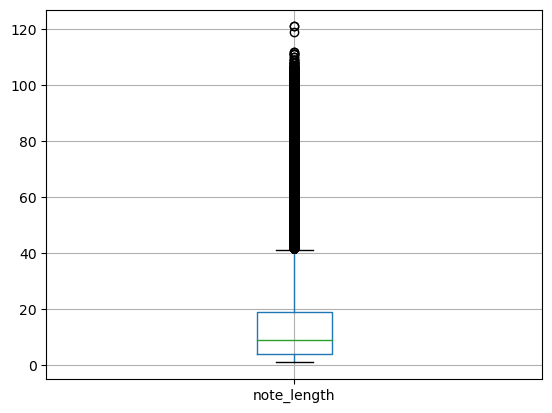

In [8]:
df.boxplot(column='note_length')

In [11]:
print(df['wine_id'].value_counts().max())
print(df['wine_id'].value_counts().mean())
print(df['wine_id'].value_counts().median())
print(df['wine_id'].value_counts().min())

16484
354.9492145662264
114.0
1
